# Projet de fin de majeure : Super résolution
#### Johanna Dubos, Zoé Ducourau & Dimitri Szezurek
---

In [46]:
# Librairies
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import shutil as shutil

from utils import *

#### Image considérée (échelle de Monoyer)

Taille de l'image : Hauteur =  256 || Largeur =  256


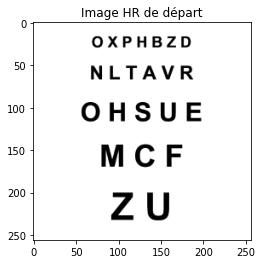

In [47]:
filename = 'monoyer-square.png'

IMAGE_nb = cv2.imread(filename,0)
#IMAGE_nb = cv2.resize(IMAGE_nb, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
[H,W] = IMAGE_nb.shape

print("Taille de l'image : Hauteur = ", H, "|| Largeur = " , W)

plt.imshow(IMAGE_nb, cmap='gray')
plt.title('Image HR de départ')
plt.show()

#### Création de la BDD avec N images (déformées, floutées, sous-échantillonées & bruitées)

In [48]:
if os.path.exists('BDD'):
    shutil.rmtree('BDD')

os.makedirs('BDD')

In [49]:
N = 10 # Nb d'images dans la BDD
sampling_rate = 4
gaussian_kernel_size = 7

M = []

for i in range (0,N):

    if i == 0:
        img_blurred = cv2.GaussianBlur(IMAGE_nb, (gaussian_kernel_size,gaussian_kernel_size), 0) # Floutage
        img_downsampled = decimation(img_blurred, sampling_rate) # Sous-échantillonnage /4

        # Ajout d'un bruit gaussien 
        gauss = np.random.normal(0,3,img_downsampled.shape)
        img_noisy = img_downsampled + gauss

        plt.imsave("BDD/imageBR.png",img_noisy,cmap='gray')

    else:
        t_max = 10
        angle = np.random.randint(-10,10)
        rotation = cv2.getRotationMatrix2D((W/2,H/2), angle, 1) # Matrice de rotation
        translation = [np.random.uniform(-t_max,t_max), np.random.uniform(-t_max,t_max)]
        rigid = rotation
        rigid[0,2] += translation[0]
        rigid[1,2] += translation[1]
        img_transformed = cv2.warpAffine(IMAGE_nb, rigid, (W,H), borderMode=cv2.BORDER_REPLICATE) # Rotation + translation
        img_blurred = cv2.GaussianBlur(img_transformed, (gaussian_kernel_size,gaussian_kernel_size), 0)# Floutage 
        img_downsampled = decimation(img_transformed, sampling_rate) # Sous-échantillonnage /4

        # Ajout d'un bruit gaussien 
        gauss = np.random.normal(0,3,img_downsampled.shape)
        img_noisy = img_downsampled + gauss

        plt.imsave("BDD/imageBR_"+str(i-1)+".png",img_noisy,cmap='gray')
        
        M_current = np.copy(rigid)
        
        # Matrice de transformation
        M.append(M_current)

#### Différentes étapes :
- Recalage/estimation du mouvement des images BR
- Estimation du flou des images BR
- Sélection d'un a priori convenable
- Estimation d'une image HR


## Recalage des images de la BDD

In [50]:

# Nombre d'images à recaler (inferieur strictement à N)

# M = [] # Liste

# fixed_img = cv2.imread('BDD/imageBR.png', 0)

# for i in range(0, N_registration):  
#     # print('BDD/imageBR_' + str(i) + '.png')  
#     moving_img = cv2.imread('BDD/imageBR_' + str(i) + '.png', 0)
#     M.append(get_transformation(fixed_img, moving_img, sampling_rate))


In [51]:
# M_test = get_transformation(fixed_img, moving_img, sampling_rate)
# plt.imshow(fixed_img, cmap = 'gray')
# interpolated = interpolation(moving_img, 2)

# moving_img = interpolation(moving_img, sampling_rate)
# registered_img = cv2.warpPerspective(moving_img, M_test, (moving_img.shape[1], moving_img.shape[0]))
# unregistered_img = cv2.warpPerspective(registered_img, M_test, (registered_img.shape[1], registered_img.shape[0]), flags = cv2.WARP_INVERSE_MAP)

# plt.subplot(141)
# plt.imshow(fixed_img, cmap='gray')
# plt.axis('off')

# plt.subplot(142)
# plt.imshow(moving_img, cmap='gray')
# plt.axis('off')

# plt.subplot(143)
# plt.imshow(registered_img, cmap='gray')
# plt.axis('off')

# plt.subplot(144)
# plt.imshow(unregistered_img, cmap='gray')
# plt.axis('off')

Text(0.5, 1.0, "crop zone d'intérêts")

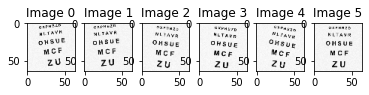

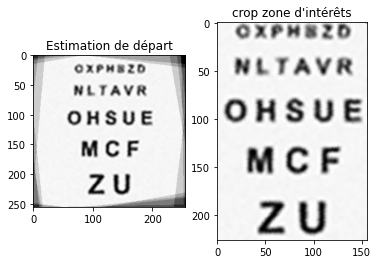

In [66]:
# Nombre d'images à recaler (inferieur strictement à N)
N_registration = 6

Y = []

Y_reference = cv2.imread('BDD/imageBR.png', 0)
plt.figure(1)
X_0 = np.zeros((np.shape(Y_reference)[0] * sampling_rate, np.shape(Y_reference)[1] * sampling_rate))
for k in range(N_registration):
      Y_current = cv2.imread('BDD/imageBR_' + str(k) + '.png', 0)
      Y.append(Y_current)
      X_0 += cv2.warpAffine(cv2.resize(Y_current, np.shape(X_0), interpolation = cv2.INTER_CUBIC), M[k], np.shape(X_0), flags = cv2.WARP_INVERSE_MAP)
      plt.subplot(1, N_registration, k+1)
      plt.imshow(Y_current, cmap = 'gray')
      plt.title("Image " + str(k))

X_k = np.copy(X_0)

plt.figure(2)
plt.subplot(121)
plt.imshow(X_k, cmap = 'gray')
plt.title("Estimation de départ")
plt.subplot(122)
plt.imshow(X_0[15:-15,50:-50], cmap='gray')
plt.title("crop zone d'intérêts")



Text(0.5, 1.0, 'Image reconstruite')

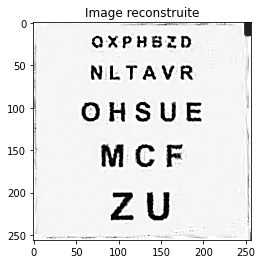

In [67]:
# super resolution gradient descent
X_k = np.copy(X_0)
MSE = [10000000000, 1000000000]
# condition d'arret
epsilon = 0.5

# parametres descente de gradient
beta = 1 # pas de descente
l = 0.05 # lambda

# parametres regul TV
gaussian_kernel = 1/16 * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
gamma = 1/8 * np.array([[1, 1,  1], [1, -8, 1], [1, 1,  1]]) # Laplacian kernel
I = np.identity(3)

# parametres regul bilateral TV
P = 3 
alpha = 0.6

while MSE[-2] - MSE[-1]> epsilon:
    
    gradient = np.zeros(np.shape(X_k)) 
    regularization = np.zeros(np.shape(X_k))
    
    for k in range(N_registration):
        # gradient
        gradient += G2(X_k, Y[k], M[k], gaussian_kernel_size, sampling_rate)         
        # regularization
        # regularization += TV(X_k, gamma)
        regularization += bilateral_TV(X_k, alpha, P)
        
    X_k = X_k - beta * (gradient + l * regularization)
    
    
    # Mean square error
    MSE_current = np.mean((X_k - IMAGE_nb)[15:-15,50:-50]**2)
    MSE.append(MSE_current)
    

plt.figure()
plt.imshow(X_k, cmap = 'gray', vmin=0, vmax=255)
plt.title("Image reconstruite")


(-0.5, 255.5, 255.5, -0.5)

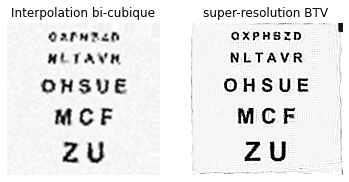

In [54]:
img_interpolated_bicubic = cv2.warpAffine(cv2.resize(Y[0], X_0.shape, interpolation = cv2.INTER_CUBIC), M[0], np.shape(X_0), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_REPLICATE)

plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(img_interpolated_bicubic, cmap='gray')
plt.title('Interpolation bi-cubique')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(X_k, cmap='gray', vmin=0, vmax=255)
plt.title('super-resolution BTV')
plt.axis('off')


MSE X_0 (interpolation bicubique moyenne) :
MSE interpolation bicubique :
MSE super résolution :1313.29454844022


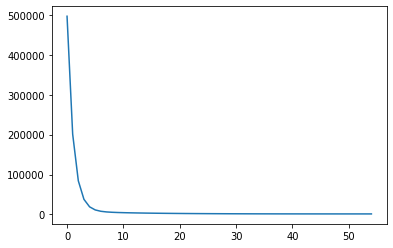

In [69]:
# plt.figure()
# hist = plt.hist(X_k.ravel(), bins = 255, range=[0, np.max(X_k)])

# np.max(X_k)

plt.figure()
plt.plot(MSE[2:])

print("MSE X_0 (interpolation bicubique moyenne) :")
print("MSE interpolation bicubique :" + str(np.mean((img_interpolated_bicubic - IMAGE_nb)[15:-15,50:-50]**2)))
print("MSE super résolution :" + str(MSE[-1]))

In [59]:
plt.imsave("super_resolution.png", X_k,cmap='gray', vmin=0, vmax=255)
plt.imsave("bicubic_moy.png", X_0, cmap='gray', vmin=0, vmax=255)
plt.imsave("bicubic.png", img_interpolated_bicubic, cmap='gray', vmin=0, vmax=255)